In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt

import tushare as ts
ts.set_token('f5cd5ac60f1cd9a51a12fa6d5980978ab630fc8f9fc8004e736ef666')
pro = ts.pro_api()

In [58]:
# Use Shanghai Electric (上海电器) as example
termCB_Test={'ConvPrice':10.72, # 转股价
             'Maturity':dt.datetime(2021,2,1), # 到期日
             'ConvertStart':5.5, # 转股期，5.5 implies 到期前5.5年
             'Coupon':[0.2,0.5,1.0,1.5,1.5,106.6], # 票息（%）
             'Recall':[5.5,15,30,130], # 赎回条款
             'Resell':[2,30,30,70,103], # 回售条款
             'Reset':[15,20,85] # 下修条款
            }

### Black Scholes

In [3]:
def _cashFlowCalc(termCoupon, dtMaturityDate, dtNowDate):
    
    # 将到期日和现在的时间翻译成datetime格式
#     dtMaturityDate = dt.datetime.strptime(strMaturityDate, '%Y/%m/%d')
#     dtNowDate = dt.datetime.strptime(strNowDate, '%Y/%m/%d')
    
    # 计算剩余期限（年）
    numPtmYears = (dtMaturityDate - dtNowDate).days/365
    
    # 计算还有哪些票息、本金未支付
    n = len(termCoupon)
    numDig, numRound = np.modf(numPtmYears) # Dig(ital)为年，Round为小数部分
    numPayment = int(np.min([numRound+1,n]))
    
    cashFlow = termCoupon[-numPayment:] # 所有要支付的现金流amount list eg. [1.5, 106.6]
    cashFlowTime = np.arange(numPayment) + numDig # 所有未来要支付现金流距离今天的支付时间 eg. [0.08493151, 1.08493151]
  
    return cashFlow, cashFlowTime

In [4]:
def _pv(cashFlow, cashFlowTime, r):
    
    pv = 0
    
    for t,cash in enumerate(cashFlow): # 折现现金流
        pv += cash/((1+r)**cashFlowTime[t])
        
    return pv

In [5]:
def bondPrice(termCoupon, strMaturityDate, strNowDate, r):
    
    # 计算债底价值
    cashFlow, cashFlowTime = _cashFlowCalc(termCoupon, strMaturityDate, strNowDate)
    price = _pv(cashFlow, cashFlowTime, r)
    
    return price

In [6]:
def blackScholes(s,x,t,vol,r):
    
    d1 = (np.log(s/x)) + (r+0.5*vol**2*t)/(np.sqrt(t)*vol)
    d2 = d1-vol*np.sqrt(t)
    c = s*norm.cdf(d1) - x*np.exp(-r*t)*norm.cdf(d2)
    
    return c

In [7]:
def cbPricingBlackScholes(stock, term, dtNowDate, vol, r):
    
    # 计算债底
    straightBondValue = bondPrice(term['Coupon'], term['Maturity'], dtNowDate, r)
    
    # 计算转股看涨期权
    s = stock
    x = term['ConvPrice']*term['Coupon'][-1]/100
    
    dtMaturityDate = term['Maturity']

#     dtMaturityDate = dt.datetime.strptime(term['Maturity'], '%Y/%m/%d')
#     dtNowDate = dt.datetime.strptime(now, '%Y/%m/%d')
    t = (dtMaturityDate - dtNowDate).days/365
    
    call = blackScholes(s,x,t,vol,np.log(1+r)*100/term['ConvPrice'])
    
    return straightBondValue + call

### Monte Carlo

In [8]:
def _cashFlowDict(termCoupon, MaturityDate, NowDate):
    cashFlow, cashFlowTime = _cashFlowCalc(termCoupon, MaturityDate, NowDate)
    dictCF = {}
    
    for i in range(len(cashFlow)):
        dictCF[round(cashFlowTime[i]*250)] = cashFlow[i]
    
#     for i, cash in enumerate(cashFlow):
#         dictCF[round(cash*250)] = cash    
    
    return dictCF # eg. {47: 1.5, 297: 106.6}

def cashFlowGenerator(dictCF, tDate):
    return dictCF[tDate] if tDate in dictCF else 0

In [130]:
def _monteCarlo(stock, vol, r, numNodes, numSimulation=10000):
    
    arrStock = np.ones([numSimulation, numNodes+1])
    dt = 1/250
    rc = np.log(1+r)
    
    arrSimulation = np.cumprod(np.exp((rc-0.5*vol**2)*dt+vol*np.sqrt(dt)*np.random.randn(numSimulation, numNodes)),axis=1)
    
    arrStock[:,1:] = arrSimulation
    arrStock *= stock
    
    return arrStock

In [56]:
def cbPricingMC(stock, term, now, vol, r, numSimulation=10000):
    
    dictCF = _cashFlowDict(term['Coupon'], term['Maturity'], now)
    
    initConvPrice = term['ConvPrice']
    
    numNodes = int(max(dictCF))

    # 每一天距离到期日的时间（年）
    arrTimeSeries = [(numNodes-i)/250 for i in range(numNodes)]
    
    arrMC = _monteCarlo(stock,vol,r,numNodes,numSimulation)
    v = []
    
    # 遍历每一条路径
    for row in arrMC:
        
        term['ConvPrice'] = initConvPrice # 重置转股价
        
        # reset = recall = resell = 0
        
        # 遍历该路径上的每一个交易日
        for i in range(numNodes):
            
            # 判断是否触发下修
            isResetTriggered, resetPrice = _processReset(term, row, i, arrTimeSeries)
            
            if isResetTriggered:
                term['ConvPrice'] = resetPrice
                # reset += 1
                
            # 判断是否触发赎回 
            isRecallTriggered, thisRowEndTime, thisRowValue = _processRecall(term, row, i, arrTimeSeries)
            
            if isRecallTriggered:
                v.append(_pvCashFlowMC(thisRowEndTime, thisRowValue, dictCF, r))
                # recall += 1
                break
                
            # 判断是否触发回售
            isResellTriggered, thisRowEndTime, thisRowValue = _processResell(term, row, i, arrTimeSeries)
            
            if isResellTriggered:
                v.append(_pvCashFlowMC(thisRowEndTime, thisRowValue, dictCF, r))
                # resell += 1
                break
                
            else:
                # 若无触发赎回、回售、下修等附加条款，计算到期价值
                thisRowEndTime = numNodes/250
                thisRowValue = np.max([100/term['ConvPrice']*row[-1], term['Coupon'][-1]]) # 则转债价值为…
                v.append(_pvCashFlowMC(thisRowEndTime, thisRowValue, dictCF, r))
                
        # print(f'reset={reset},recall={recall},resell={resell}')
        
                
    return np.mean(v)

In [11]:
def _sliceInMC(array, point, length):
    # 将路径切片，分析条款触发情况
    # 从point往前切片长度为length的array，若length > point，则截取可合法获得的最大长度
    return array[int(max([0,point-length])):int(point)]

def _isRecall(arrStockPrice, arrTimeSeries, recallPeriod, recallThreashold, recallLevel):
    
    validTime = np.array(arrTimeSeries) < recallPeriod # 若剩余时间小于5.5，说明此时可以转股，则当日时间合法
    validPrice = arrStockPrice > recallLevel # 若当期股价高于回售价（i.e., 130%*转股价），当日价格合法
    
    return True if np.sum(validTime*validPrice) >= recallThreashold else False # 若合法的总天数大于15，则赎回触发，返回True

def _isResell(arrStockPrice, arrTimeSeries, resellThreashold, resellObsInterval, resellLevel):
    
    validTime = np.array(arrTimeSeries) < resellObsInterval # 处于最后两年，则合法
    validPrice = arrStockPrice < resellLevel # 股价低于70%*转股价，则合法
    
    return True if np.sum(validTime*validPrice) >= resellThreashold else False # 若合法的总天数大于30，则回售触发，返回True

def _isReset(arrStockPrice, resetThreashold, resetObsInterval, resetLevel):
    
    validPrice = arrStockPrice < resetLevel # 股价低于85%*转股价，则合法
    
    return True if np.sum(1*validPrice) >= resetThreashold else False
    
def _pvCashFlowMC(thisRowEndTime, thisRowValue, dictCF, r): # 折现蒙特卡洛模拟每一条路径的支付
    
    cfT = [thisRowEndTime]
    cf = [thisRowValue]
    
    for time in dictCF:
        if time/250 < thisRowEndTime:
            cfT.append(time/250)
            cf.append(dictCF[time])
            
    return _pv(cf, cfT, r)

In [55]:
def _processRecall(term, row, i, arrTimeSeries):
    
    recallPeriod = term['Recall'][0] # 5.5
    recallThreashold = term['Recall'][1] # 15
    recallObsInterval = term['Recall'][2] # 30
    recallLevel = term['Recall'][3]/100*term['ConvPrice'] # 130

    if row[i] > recallLevel: # 如果当期模拟价格大于130%*转股价，观察连续30交易日正股股价，以判断是否触发赎回
        
        sliceArrStockPrice = _sliceInMC(row, i, recallObsInterval)
        sliceArrTimeSeries = _sliceInMC(arrTimeSeries, i, recallObsInterval)
        
        isRecallTriggered = _isRecall(sliceArrStockPrice, sliceArrTimeSeries, recallPeriod, recallThreashold, recallLevel)
        
        if isRecallTriggered: 
            thisRowEndTime = i/250
            thisRowValue = (100/term['ConvPrice'])*row[i] # 若赎回触发，则该路径上的支付为：(100/转股价)*正股股价
        else:
            thisRowEndTime = None
            thisRowValue = None
            
        return isRecallTriggered, thisRowEndTime, thisRowValue
    
    else: 
        return [None]*3
    

def _processResell(term, row, i, arrTimeSeries):
    
    resellBegin = term['Resell'][0] # 回售只从最后2年开始
    resellThreashold = term['Resell'][1] # 至少30 out of 30观察日 
    resellObsInterval = term['Resell'][2] # 观察期连续30日
    resellLevel = term['Resell'][3]/100*term['ConvPrice'] # 股价低于70%*转股价
    resellPrice = term['Resell'][4] # 按103%*par回售
    
    if row[i] < resellLevel:
        sliceArrStockPrice = _sliceInMC(row,i,resellObsInterval)
        sliceArrTimeSeries = _sliceInMC(arrTimeSeries,i,resellObsInterval)
        
        isResellTriggered = _isResell(sliceArrStockPrice, sliceArrTimeSeries, 
                                      resellThreashold, resellObsInterval, resellLevel)
    
        if isResellTriggered:
            thisRowEndTime = i/250
            thisRowValue = resellPrice
        else:
            thisRowEndTime = None
            thisRowValue = None
            
        return isResellTriggered, thisRowEndTime, thisRowValue
    
    else:
        return [None]*3
    

def _processReset(term, row, i, arrTimeSeries):
    
    resetThreashold = term['Reset'][0] # 20个观察日
    resetObsInterval = term['Reset'][1] # out of 30
    resetLevel = term['Reset'][2]/100*term['ConvPrice'] # 股价低于85%*转股价
    
    if row[i] < resetLevel:
        
        sliceArrStockPrice = _sliceInMC(row,i,resetObsInterval)
    
        isResetTriggered = _isReset(sliceArrStockPrice, resetThreashold, resetObsInterval, resetLevel)
        
        if isResetTriggered:
            
            # 修正转股价 >= max(last close, mean(last 20 days close))
            resetPrice = np.max([np.mean(sliceArrStockPrice), sliceArrStockPrice[-1]]) 

            return isResetTriggered, resetPrice
        else:
            return None, None
        
    else:
        return None, None

In [13]:
cbPricingBlackScholes(9.5, termCB_Test, dt.datetime(2017,7,27), vol=0.2, r=0.03)

104.41046134415932

In [61]:
cbPricingMC(9.5, termCB_Test, dt.datetime(2017,7,27), vol=0.2, r=0.03,numSimulation=10000)

154.35516873095185

### Take a look at the real data: backtest

In [15]:
cb_ticker = '113008.SH'
cb_ts = pro.cb_daily(ts_code=cb_ticker).sort_values(by=['trade_date']).set_index('trade_date')
cb_ts.index = pd.to_datetime(cb_ts.index)
cb_ts

,ts_code,pre_close,open,high,low,close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2015-02-16,113008.SH,100.00,131.01,140.01,130.00,133.31,33.31,33.3100,793176.0,105494.9469
2015-02-17,113008.SH,133.31,132.15,136.52,130.34,136.14,2.83,2.1229,1077133.0,144620.6086
2015-02-25,113008.SH,136.14,136.20,136.50,132.76,132.99,-3.15,-2.3138,618879.0,82808.3749
2015-02-26,113008.SH,132.99,132.66,133.99,131.71,133.52,0.53,0.3985,438593.0,58162.8200
2015-02-27,113008.SH,133.52,134.10,134.51,133.20,134.09,0.57,0.4269,363570.0,48732.0404
...,...,...,...,...,...,...,...,...,...,...
2021-01-26,113008.SH,106.48,0.00,0.00,0.00,106.48,0.00,0.0000,0.0,0.0000
2021-01-27,113008.SH,106.48,0.00,0.00,0.00,106.48,0.00,0.0000,0.0,0.0000
2021-01-28,113008.SH,106.48,0.00,0.00,0.00,106.48,0.00,0.0000,0.0,0.0000


In [37]:
eq_ticker = '601727.SH'
eq_ts = pro.daily(ts_code=eq_ticker).sort_values(by=['trade_date']).set_index('trade_date')
eq_ts.index = pd.to_datetime(eq_ts.index)
eq_ts

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2008-12-05,601727.SH,6.00,7.66,5.68,6.80,4.78,2.02,42.2600,3149936.11,2113599.943
2008-12-08,601727.SH,6.71,7.48,6.70,7.48,6.80,0.68,10.0000,1599237.19,1128523.953
2008-12-09,601727.SH,7.78,8.12,7.41,7.69,7.48,0.21,2.8100,2465710.07,1916496.617
2008-12-10,601727.SH,7.49,7.67,7.31,7.54,7.69,-0.15,-1.9500,1187652.39,890477.729
2008-12-11,601727.SH,7.52,7.56,6.93,7.12,7.54,-0.42,-5.5700,1369331.76,981496.844
...,...,...,...,...,...,...,...,...,...,...
2021-07-26,601727.SH,3.99,3.99,3.91,3.94,4.00,-0.06,-1.5000,487447.56,191929.387
2021-07-27,601727.SH,3.94,3.96,3.90,3.91,3.94,-0.03,-0.7614,354938.19,139677.036
2021-07-28,601727.SH,3.88,3.88,3.73,3.78,3.91,-0.13,-3.3248,588508.74,223041.881


In [17]:
cb_price_chg = pro.cb_price_chg(ts_code=cb_ticker).set_index('change_date', drop=True)
cb_price_chg.index = pd.to_datetime(cb_price_chg.index)
cb_price_chg = cb_price_chg.fillna(value=10.72)
cb_price_chg

,ts_code,bond_short_name,publish_date,convert_price_initial,convertprice_bef,convertprice_aft
change_date,,,,,,
2015-02-02,113008.SH,电气转债,20150129,10.72,10.72,10.72
2015-07-02,113008.SH,电气转债,20150625,10.72,10.72,10.66
2016-11-28,113008.SH,电气转债,20161125,10.72,10.66,10.65
2017-10-24,113008.SH,电气转债,20171023,10.72,10.65,10.46
2017-11-09,113008.SH,电气转债,20171108,10.72,10.46,10.37
2018-08-28,113008.SH,电气转债,20180821,10.72,10.37,10.28
2018-12-12,113008.SH,电气转债,20181211,10.72,10.28,5.19
2019-08-08,113008.SH,电气转债,20190731,10.72,5.19,5.13


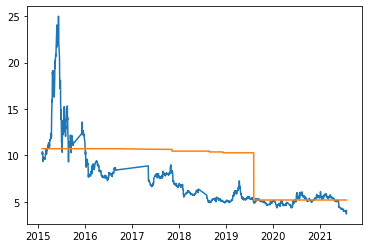

In [102]:
# stock price vs. conversion price

eq_ts['conv_price'] = 0
eq_ts_copy = eq_ts.copy()

for date in eq_ts.index:
    try:
        currentConvPrice = cb_price_chg.iloc[cb_price_chg.index.get_loc(date, 'ffill')]['convertprice_bef']
    except:
        currentConvPrice = cb_price_chg.iloc[cb_price_chg.index.get_loc(date, 'bfill')]['convertprice_bef']
    eq_ts_copy.loc[date,'conv_price'] = currentConvPrice

plt.plot(eq_ts_copy.loc['2015-02':'2021'].close)
plt.plot(eq_ts_copy.loc['2015-02':'2021'].conv_price)

In [96]:
eq_ts

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,conv_price
trade_date,,,,,,,,,,,
2008-12-05,601727.SH,6.00,7.66,5.68,6.80,4.78,2.02,42.2600,3149936.11,2113599.943,NaN
2008-12-08,601727.SH,6.71,7.48,6.70,7.48,6.80,0.68,10.0000,1599237.19,1128523.953,NaN
2008-12-09,601727.SH,7.78,8.12,7.41,7.69,7.48,0.21,2.8100,2465710.07,1916496.617,NaN
2008-12-10,601727.SH,7.49,7.67,7.31,7.54,7.69,-0.15,-1.9500,1187652.39,890477.729,NaN
2008-12-11,601727.SH,7.52,7.56,6.93,7.12,7.54,-0.42,-5.5700,1369331.76,981496.844,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,601727.SH,3.99,3.99,3.91,3.94,4.00,-0.06,-1.5000,487447.56,191929.387,NaN
2021-07-27,601727.SH,3.94,3.96,3.90,3.91,3.94,-0.03,-0.7614,354938.19,139677.036,NaN
2021-07-28,601727.SH,3.88,3.88,3.73,3.78,3.91,-0.13,-3.3248,588508.74,223041.881,NaN


In [18]:
def movingWindomVol(array, window=250):
    return np.std(np.diff(np.log(array[-window:])))*np.sqrt(250)

In [119]:
simulationFromBS = []
simulationFromMC = []

# Use Shanghai Electric (上海电器) as example
termCB_Test={'ConvPrice':10.72, # 转股价
             'Maturity':dt.datetime(2021,2,1), # 到期日
             'ConvertStart':5.5, # 转股期，5.5 implies 到期前5.5年
             'Coupon':[0.2,0.5,1.0,1.5,1.5,106.6], # 票息（%）
             'Recall':[5.5,15,30,130], # 赎回条款
             'Resell':[2,30,30,70,103], # 回售条款
             'Reset':[15,20,85] # 下修条款
            }


convChangeDate = cb_price_chg.index

# eq_vol_array = []

for date in tqdm.tqdm(cb_ts.index[:-1]):

    if date in convChangeDate:
        termCB_Test['ConvPrice'] = cb_price_chg.loc[date, 'convertprice_bef']
    
    stockPriceIdx = eq_ts.index.get_loc(date, 'ffill')
    todayStockPrice = eq_ts.iloc[stockPriceIdx]['close']
    
#     array = eq_ts.iloc[:stockPriceIdx]['close'].to_list()    
#     eq_vol = movingWindomVol(array) # 观察一个季度的波动率？  
#     if eq_vol > 0.6:
#         eq_vol = eq_vol*0.6

    eq_vol = 0.4

    # eq_vol_array.append(eq_vol)
    
    bs = cbPricingBlackScholes(todayStockPrice, termCB_Test, date, vol=vol, r=0.05)
    mc = cbPricingMC(todayStockPrice, termCB_Test, date, vol=vol, r=0.05, numSimulation=200)

    simulationFromMC.append(mc)
    simulationFromBS.append(bs)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1452/1452 [03:13<00:00,  7.51it/s]


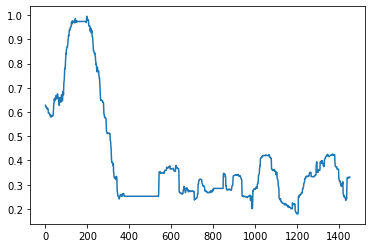

In [63]:
plt.plot(vol_array)

In [45]:
# # Use Shanghai Electric (上海电器) as example
# termCB_Test={'ConvPrice':100, # 转股价
#              'Maturity':dt.datetime(2022,3,10), # 到期日
#              'ConvertStart':5.5, # 转股期，5.5 implies 到期前5.5年
#              'Coupon':[0.2,0.5,1.0,1.5,1.5,106.6], # 票息（%）
#              'Recall':[5.5,15,30,130], # 赎回条款
#              'Resell':[2,30,30,70,103], # 回售条款
#              'Reset':[15,20,85] # 下修条款
#             }
# cbPricingMC(100,termCB_Test, dt.datetime(2018,3,10),0.1,0.05,numSimulation=100)

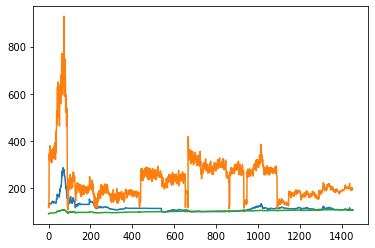

In [120]:
plt.plot(list(cb_ts.close))
plt.plot(simulationFromMC)
plt.plot(simulationFromBS)
plt.show()

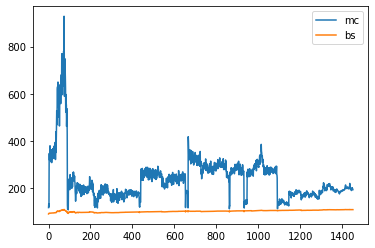

In [121]:
plt.plot(simulationFromMC, label='mc')
plt.plot(simulationFromBS, label='bs')
plt.legend()
plt.show()

In [109]:
cb_ts.close.describe()

count    1453.000000
mean      116.845409
std        22.499044
min        98.800000
25%       106.800000
50%       113.000000
75%       116.860000
max       286.710000
Name: close, dtype: float64

In [110]:
# Rating issue?
cb = pd.read_excel('CB info.xlsx',sheet_name='cb_list').set_index('名称')
cb_dict = dict(zip(cb.loc['正股代码'], cb.loc['代码']))
cb

,光大转债,宁行转债,平银转债,中信转债,苏银转债,电气转债,现代转债,浙商转债,国君转债,长证转债,...,浦发转债,川投转债,核能转债,核建转债,顺丰转债,希望转债,淮矿转债,环境转债,烽火转债,国贸转债
名称,,,,,,,,,,,,,,,,,,,,,
代码,113011.SH,128024.SZ,127010.SZ,113021.SH,110053.SH,113008.SH,110057.SH,113022.SH,113013.SH,127005.SZ,...,110059.SH,110061.SH,113026.SH,113024.SH,128080.SZ,127015.SZ,110065.SH,113028.SH,110062.SH,110033.SH
正股代码,601818.SH,002142.SZ,000001.SZ,601998.SH,600919.SH,601727.SH,600420.SH,601878.SH,601211.SH,000783.SZ,...,600000.SH,600674.SH,601985.SH,601611.SH,002352.SZ,000876.SZ,600985.SH,601200.SH,600498.SH,600755.SH


In [126]:
def cbBackTest(eq_ticker, cb_ticker):
    
    cb_ts = pro.cb_daily(ts_code=cb_ticker).sort_values(by=['trade_date']).set_index('trade_date')
    cb_ts.index = pd.to_datetime(cb_ts.index)
    
    eq_ts = pro.daily(ts_code=eq_ticker).sort_values(by=['trade_date']).set_index('trade_date')
    eq_ts.index = pd.to_datetime(eq_ts.index)
        
    termCB={'ConvPrice':0, # 转股价
             'Maturity':0, # 到期日
             'ConvertStart':5.5, # 转股期，5.5 implies 到期前5.5年
             'Coupon':[0.2,0.5,1.0,1.5,1.5,106.6], # 票息（%）
             'Recall':[5.5,15,30,130], # 赎回条款
             'Resell':[2,30,30,70,103], # 回售条款
             'Reset':[15,20,85] # 下修条款
            }
    
    basics = pro.cb_basic(ts_code=cb_ticker)
    termCB['ConvPrice'] = float(basics.first_conv_price)
    
    
    cb_price_chg = pro.cb_price_chg(ts_code=cb_ticker).set_index('change_date', drop=True)
    cb_price_chg.index = pd.to_datetime(cb_price_chg.index)
    cb_price_chg = cb_price_chg.fillna(value=termCB['ConvPrice'])

    
    maturity = basics.maturity_date[0]
    maturity = dt.datetime.strptime(maturity, '%Y-%m-%d')
    termCB['Maturity'] = maturity 
    print(termCB)

cbBackTest('601818.SH','113011.SH')

{'ConvPrice': 4.36, 'Maturity': datetime.datetime(2023, 3, 17, 0, 0), 'ConvertStart': 5.5, 'Coupon': [0.2, 0.5, 1.0, 1.5, 1.5, 106.6], 'Recall': [5.5, 15, 30, 130], 'Resell': [2, 30, 30, 70, 103], 'Reset': [15, 20, 85]}


In [141]:
def cbBackTest(eq_ticker, cb_ticker):
    
    cb_ts = pro.cb_daily(ts_code=cb_ticker).sort_values(by=['trade_date']).set_index('trade_date')
    cb_ts.index = pd.to_datetime(cb_ts.index)
    
    eq_ts = pro.daily(ts_code=eq_ticker).sort_values(by=['trade_date']).set_index('trade_date')
    eq_ts.index = pd.to_datetime(eq_ts.index)
        
    termCB={'ConvPrice':0, # 转股价
             'Maturity':0, # 到期日
             'ConvertStart':5.5, # 转股期，5.5 implies 到期前5.5年
             'Coupon':[0.2,0.5,1.0,1.5,1.5,106.6], # 票息（%）
             'Recall':[5.5,15,30,130], # 赎回条款
             'Resell':[2,30,30,70,103], # 回售条款
             'Reset':[15,20,85] # 下修条款
            }
    
    basics = pro.cb_basic(ts_code=cb_ticker)
    termCB['ConvPrice'] = float(basics.first_conv_price)
    
    
    cb_price_chg = pro.cb_price_chg(ts_code=cb_ticker).set_index('change_date', drop=True)
    cb_price_chg.index = pd.to_datetime(cb_price_chg.index)
    cb_price_chg = cb_price_chg.fillna(value=termCB['ConvPrice'])

    
    maturity = basics.maturity_date[0]
    maturity = dt.datetime.strptime(maturity, '%Y-%m-%d')
    termCB['Maturity'] = maturity    
    
    simulationFromBS = []
    simulationFromMC = []

    convChangeDate = cb_price_chg.index
    
    
    for date in tqdm.tqdm(cb_ts.index[:-1]):
        
        if date in convChangeDate:
            termCB['ConvPrice'] = cb_price_chg.loc[date, 'convertprice_bef']

        stockPriceIdx = eq_ts.index.get_loc(date, 'ffill')
        todayStockPrice = eq_ts.iloc[stockPriceIdx]['close']

        array = eq_ts.iloc[:stockPriceIdx]['close'].to_list()    
        eq_vol = movingWindomVol(array) # 观察一个季度的波动率？  

        bs = cbPricingBlackScholes(todayStockPrice, termCB, date, vol=vol, r=0.05)
        mc = cbPricingMC(todayStockPrice, termCB, date, vol=vol, r=0.05, numSimulation=200)

        simulationFromMC.append(mc)
        simulationFromBS.append(bs)
    
    
    simulationFromMC.append(np.nan)
    simulationFromBS.append(np.nan)
    
    cb_ts['mc'] = simulationFromMC 
    cb_ts['bs'] = simulationFromBS
    
    plt.figure()
    plt.plot(cb_ts.close, label=cb_ticker)
    plt.plot(cb_ts.mc, label='mc')
    plt.plot(cb_ts.bs, label='bs')
    plt.legend()
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1054/1054 [02:29<00:00,  7.06it/s]


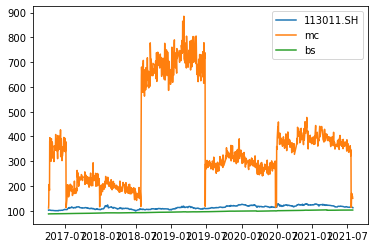

100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [01:20<00:00,  4.87it/s]


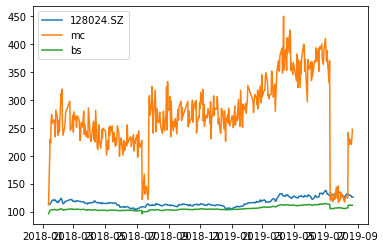

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [00:48<00:00,  3.03it/s]


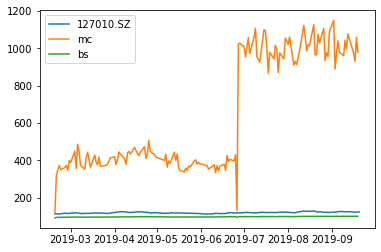

100%|████████████████████████████████████████████████████████████████████████████████| 577/577 [01:51<00:00,  5.18it/s]


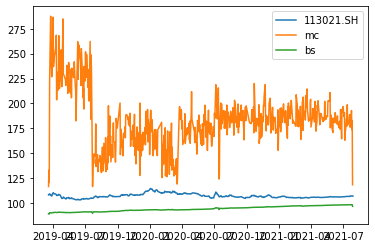

100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [01:52<00:00,  5.05it/s]


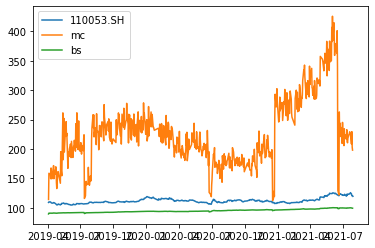

100%|██████████████████████████████████████████████████████████████████████████████| 1452/1452 [03:08<00:00,  7.70it/s]


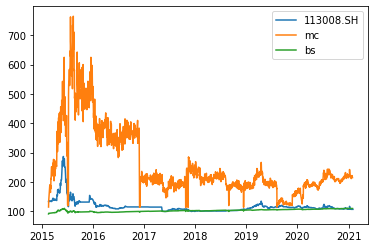

100%|████████████████████████████████████████████████████████████████████████████████| 548/548 [01:44<00:00,  5.26it/s]


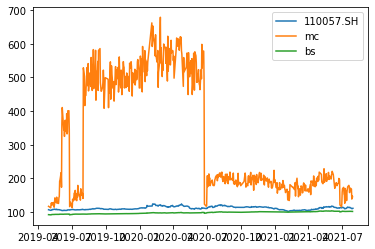

100%|████████████████████████████████████████████████████████████████████████████████| 344/344 [01:20<00:00,  4.27it/s]


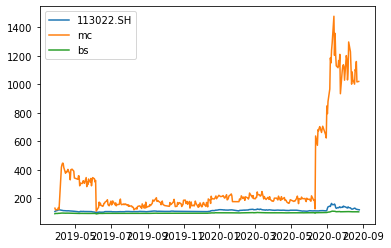

100%|████████████████████████████████████████████████████████████████████████████████| 979/979 [02:11<00:00,  7.43it/s]


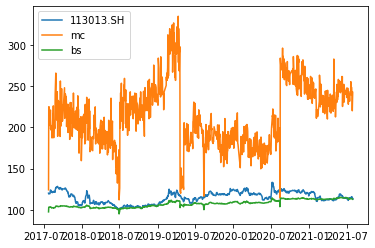

100%|████████████████████████████████████████████████████████████████████████████████| 805/805 [01:53<00:00,  7.09it/s]


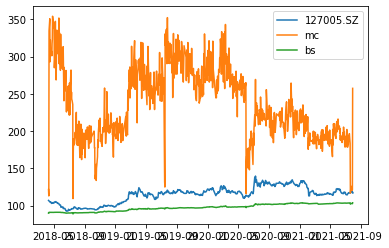

100%|██████████████████████████████████████████████████████████████████████████████| 1334/1334 [03:33<00:00,  6.26it/s]


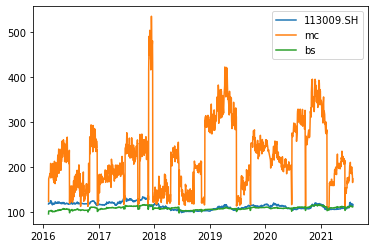

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:55<00:00,  3.96it/s]


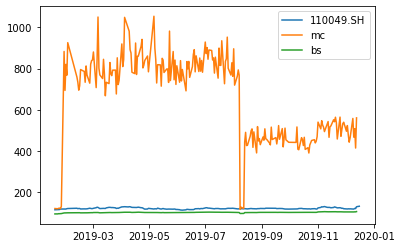

100%|████████████████████████████████████████████████████████████████████████████████| 482/482 [01:25<00:00,  5.65it/s]


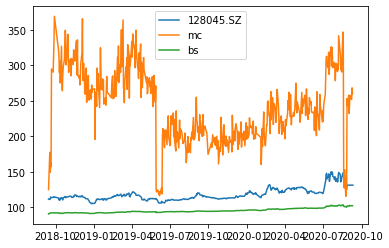

100%|████████████████████████████████████████████████████████████████████████████████| 643/643 [01:41<00:00,  6.32it/s]


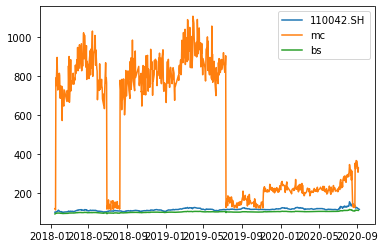

100%|████████████████████████████████████████████████████████████████████████████████| 548/548 [01:27<00:00,  6.29it/s]


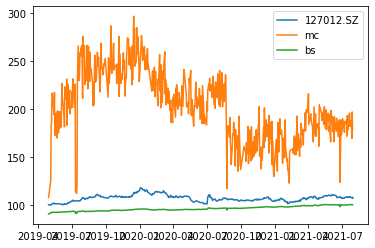

100%|██████████████████████████████████████████████████████████████████████████████| 1449/1449 [03:08<00:00,  7.67it/s]


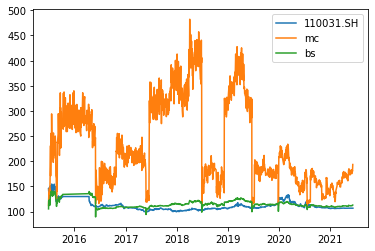

100%|████████████████████████████████████████████████████████████████████████████████| 864/864 [02:00<00:00,  7.17it/s]


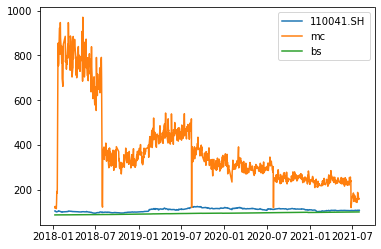

100%|████████████████████████████████████████████████████████████████████████████████| 415/415 [01:18<00:00,  5.30it/s]


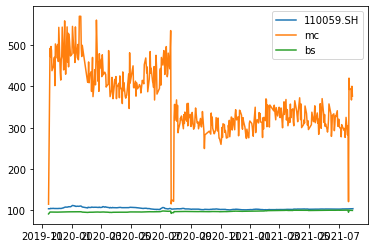

100%|████████████████████████████████████████████████████████████████████████████████| 404/404 [01:16<00:00,  5.30it/s]


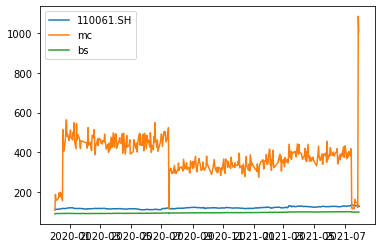

100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [01:42<00:00,  5.30it/s]


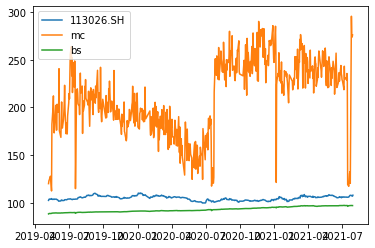

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [01:45<00:00,  5.19it/s]


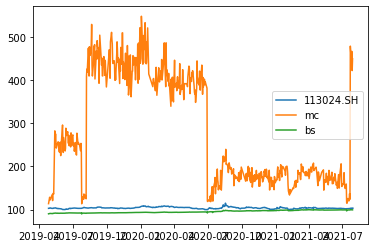

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:59<00:00,  2.64it/s]


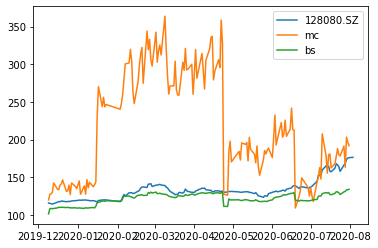

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [01:19<00:00,  4.61it/s]


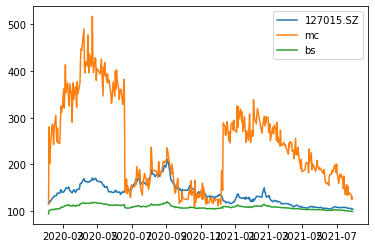

100%|████████████████████████████████████████████████████████████████████████████████| 354/354 [01:12<00:00,  4.85it/s]


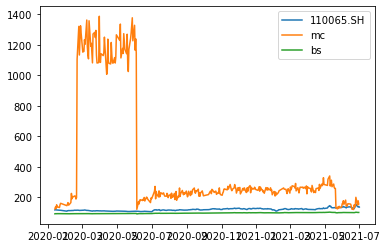

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [01:06<00:00,  4.42it/s]


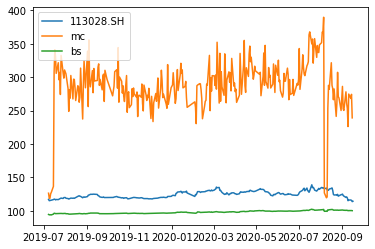

100%|████████████████████████████████████████████████████████████████████████████████| 387/387 [01:24<00:00,  4.60it/s]


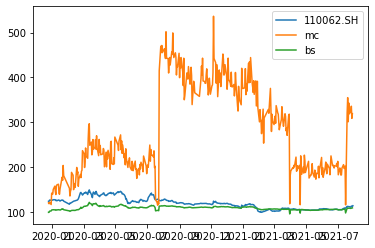

100%|██████████████████████████████████████████████████████████████████████████████| 1346/1346 [02:50<00:00,  7.89it/s]


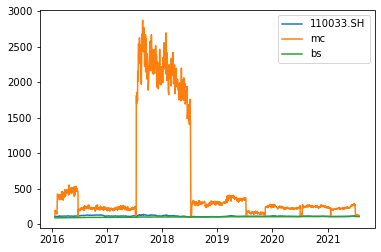

In [142]:
for equity in cb_dict:
    conv = cb_dict[equity]
    cbBackTest(equity, conv)